# Predicción de ventas para Corporación Favorita

## Tabla de contenidos
[A. Definición del objetivo del problema](#a-definición-del-objetivo-del-problema)

[B. Recopilación de la información](#b-recopilación-de-la-información)
- [Días festivos](#días-festivos)
- [Petróleo](#petróleo)
- [Tiendas](#tiendas)
- [Train](#train)
- [Test](#test)
- [Transacciones](#transacciones)

[C. Overview y limpieza de la información](#c-overview-y-limpieza-de-la-información)
- [Días festivos](#limpieza-y-overview-días-festivos)
- [Petróleo](#limpieza-y-overview-petróleo)
- [Tiendas](#overview-tiendas)
- [Train](#overview-train)
- [Transacciones](#overview-transacciones)

[D. Visualización y relación entre features](#d-visualización-y-relación-entre-features)

[E. Análisis estadístico](#e-análisis-estadístico)

[F. Feature engineering](#f-feature-engineering)

[G. Tareas previas al modelo](#g-tareas-previas-al-modelo)

[H. Modelado](#h-modelado)

[I. Entrega de resultados](#i-entrega-de-resultado)


## A. Definición del objetivo del problema
Se busca obtener un modelo para predecir las ventas de Corporación Favorita, un supermercado ecuatoriano. Se busca que el modelo prediga con certeza las unidades de ventas para el supermercado con respecto al tiempo. 

## B. Recopilación de la información


### Días festivos
Los días festivos pueden proveer más tiempo para ir al supermercado o propiciar eventos familiares o de amigos que motiven a las personas a realizar más compras que no harían normalmente.  

| Columna | Descripción |
| :--- | :--- |
| date | Fecha del día festivo |
| type | tipo de día festivo, si fue *Transferred* se celebró ese día cuando el día oficial es otro, si fue *Bridge* se agregó a otro |
| locale | A que nivel se celebró el día festivo (local, regional, nacional) |
| locale_name | en que localidad se celebró |
| description | descripción del día festivo |
| transfer | indica si el festivo se celebró en otra fecha, si el valor es verdadero la fecha en la que se celebró se indica con la columna **type** |

### Petróleo
Al ser un país dependiente del petróleo, el precio de este puede influir en las ventas del supermercado.  

| Columna | Descripción |
| :--- | :--- |
| date | Fecha de la cotización del precio |
| dcoilwtico | precio del petroleo en la fecha |

### Tiendas
Información sobre cada tienda.  

| Columna | Descripción |
| :--- | :--- |
| city | Ciudad |
| state | Estado |
| type | Tipo de tienda |
| cluster | agrupamiento de tiendas similares |

### Train
Datos de entrenamiento del modelo, se deberá usar la columna de **sales** como variable a predecir.  

| Columna | Descripción |
| :--- | :--- |
| id | identificador único de la venta |
| date | Fecha de cada venta individual |
| store_nbr | tienda en la que se realizó la venta |
| family | familia de producto de la que se hizo la venta |
| sales | unidades vendidas de la familia de productos | 
| onpromotion | cantidad de artículos de la familia de productos que estaba en promoción | 

### Test
Datos para probar el modelo, igual que train menos la columna de **sales** ya que es la variable a predecir.  

| Columna | Descripción |
| :--- | :--- |
| id | identificador único de la venta |
| date | Fecha de cada venta individual |
| store_nbr | tienda en la que se realizó la venta |
| family | familia de producto de la que se hizo la venta |
| onpromotion | cantidad de artículos de la familia de productos que estaba en promoción | 


### Transacciones

Datos de las transaccciones totales para cada tienda.  

| Columna | Descripción |
| :--- | :--- |
| id | identificador único de la venta |
| date | Fecha de cada venta individual |
| store_nbr | tienda en la que se realizó la venta |
| family | familia de producto de la que se hizo la venta |
| onpromotion | cantidad de artículos de la familia de productos que estaba en promoción | 

## C. Overview y limpieza de la información

In [70]:
# Common tasks libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaeneous libraries.
import re
from datetime import timedelta
from joblib import dump, load

# Common tasks sklearn libraries.
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Modeling sklearn libraries.
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

# PCA sklearn.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Debido a que la mayoría de las variables tienen los 100% completos, solamente se hará una ligera limpieza a Días Festivos y a Petróleo. Todas las variables se modificarán para que ahora su índice sea la fecha y se tratarán como variables tipo fecha de pandas.

In [7]:
def add_datepart(df, fldname, drop=True, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_quarter_end', 'Is_quarter_start']
    for n in attr:
        if n == 'Week':
            df[targ_pre + n] = [ts.isocalendar().week for ts in fld]
        else:
            df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)

### Limpieza y overview Días festivos

In [17]:
# Vamos a suponer que day of week de asueto tiene que ser en 4 que es friday
def adjust_holidays(prevdf, daycol, boolcol):
    df = prevdf[prevdf[boolcol] == True]
    lst = []
    for i, dfiter in enumerate(df[daycol]):
        dayweek = dfiter.dayofweek
        dateNum = 4 - dayweek
        newDate = []
        newDate = [pd.Timestamp(dfiter.to_pydatetime() + timedelta(days=dateNum))]
        for item in df[[j for j in df.columns if j not in (daycol,boolcol)]].iloc[i].values:
            newDate.append(item)
        newDate.append(False)
        lst.append(newDate)
    newdf = prevdf[prevdf[boolcol] == False]
    newdf.reset_index(inplace = True, drop = True)
    newreg = pd.DataFrame(lst,columns = df.columns)
    return pd.concat(objs = (newdf,newreg))

holidays_df = pd.read_csv('./data/holidays_events.csv', parse_dates = ['date'])
mask_holidays = holidays_df['date'].dt.year != 2012
holidays_df_new = holidays_df[mask_holidays]
holidays_df_new.reset_index(inplace=True, drop=True)
holidays_df_new = adjust_holidays(holidays_df_new, 'date', 'transferred')
holidays_df_new

,date,type,locale,locale_name,description,transferred
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
2,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
3,2013-02-11,Holiday,National,Ecuador,Carnaval,False
4,2013-02-12,Holiday,National,Ecuador,Carnaval,False
...,...,...,...,...,...,...
6,2017-04-14,Holiday,Local,Cuenca,Fundacion de Cuenca,False
7,2017-05-26,Holiday,National,Ecuador,Batalla de Pichincha,False
8,2017-08-11,Holiday,National,Ecuador,Primer Grito de Independencia,False
9,2017-09-29,Holiday,Local,Ibarra,Fundacion de Ibarra,False


### Limpieza y overview Petróleo

In [22]:
oil_prices_df = pd.read_csv('./data/oil.csv')
oil_prices_df = oil_prices_df.dropna()
print(oil_prices_df.shape)
add_datepart(oil_prices_df,'date',False)
oil_prices_df.head()

(1175, 2)


,date,dcoilwtico,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end,Is_quarter_start
1,2013-01-02,93.14,2013,1,1,2,2,2,False,False
2,2013-01-03,92.97,2013,1,1,3,3,3,False,False
3,2013-01-04,93.12,2013,1,1,4,4,4,False,False
4,2013-01-07,93.20,2013,1,2,7,0,7,False,False
5,2013-01-08,93.21,2013,1,2,8,1,8,False,False


### Overview Tiendas

In [23]:
stores_df = pd.read_csv('./data/stores.csv')
print(stores_df.shape)
stores_df.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Overview Train

In [26]:
# Join with holidays
def holidays_on_dataset(df, dfhol, dfcols, dfholcols, dfcolsfinal):
    # values
    dfcols1, dfcols2, dfcols3 = dfcols
    dfholcols1, dfholcols2, dfholval = dfholcols
    
    # local holidays
    local_holidays = pd.merge(left = df, right = dfhol, how = 'inner', 
                             right_on = dfholcols1, left_on = dfcols1)
    local_holidays['is_holiday_local'] = 1
    dfcolsfinal.append('is_holiday_local')
    
    # national holidays
    national_holidays = pd.merge(left = df[[dfcols2]], right = dfhol, how = 'inner', on = dfcols2)
    national_holidays = national_holidays[national_holidays[dfholcols2] == dfholval].reset_index(drop = True)
    national_holidays['is_holiday_national'] = 1
    dfcolsfinal.append('is_holiday_national')
    
    # holidays
    local_national_holidays = pd.concat(objs = (local_holidays, national_holidays)).reset_index(drop = True)
    local_national_holidays = local_national_holidays[dfcols3]
    
    # Fill nulls
    lstvals = [dfholval,0,0]
    for elem,name in enumerate(local_national_holidays.columns[1:]):
        local_national_holidays[name] = local_national_holidays[name].fillna(lstvals[elem])
    
    # new holidays df
    local_national_holidays.drop_duplicates(inplace = True)
    local_national_holidays.sort_values(by = dfcols2, inplace = True)
    local_national_holidays.reset_index(inplace = True, drop = True)
    
    # Join to df
    new_df = pd.merge(left = df, right = local_national_holidays, how = 'left', on = dfcols2)
    
    # Grab by columns
    new_df = new_df[dfcolsfinal]
    new_df['is_holiday_local'] = new_df['is_holiday_local'].fillna(0)
    new_df['is_holiday_national'] = new_df['is_holiday_national'].fillna(0)
    
    # Return the df now refactorized
    return new_df

In [27]:
train_df = pd.read_csv('./data/train.csv', parse_dates = ['date'], index_col = 0)
train_group_df = train_df.groupby(by=['family','date','store_nbr']).sum().reset_index()

# Join with stores
train_join_df = pd.merge(left = train_group_df, right = stores_df, on = 'store_nbr', how = 'inner')
add_datepart(train_join_df,'date',False)

# Adjust holidays
train_join_df = holidays_on_dataset(train_join_df, holidays_df_new, 
                [['date','city'],'date',['date','city','is_holiday_local','is_holiday_national']],
                [['date','locale_name'],'locale','National'],
                ['family','date','store_nbr', 'sales','onpromotion','city_x','state','type','cluster',
                'Year','Month','Week','Day','Dayofweek','Dayofyear','Is_quarter_end','Is_quarter_start'])

train_join_df

,family,date,store_nbr,sales,onpromotion,city_x,state,type,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end,Is_quarter_start,is_holiday_local,is_holiday_national
0,AUTOMOTIVE,2013-01-01,1,0.0,0,Quito,Pichincha,D,13,2013,1,1,1,1,1,False,True,0.0,1.0
1,AUTOMOTIVE,2013-01-02,1,2.0,0,Quito,Pichincha,D,13,2013,1,1,2,2,2,False,False,0.0,0.0
2,AUTOMOTIVE,2013-01-03,1,3.0,0,Quito,Pichincha,D,13,2013,1,1,3,3,3,False,False,0.0,0.0
3,AUTOMOTIVE,2013-01-04,1,3.0,0,Quito,Pichincha,D,13,2013,1,1,4,4,4,False,False,0.0,0.0
4,AUTOMOTIVE,2013-01-05,1,5.0,0,Quito,Pichincha,D,13,2013,1,1,5,5,5,False,False,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038305,SEAFOOD,2017-08-11,54,0.0,0,El Carmen,Manabi,C,3,2017,8,32,11,4,223,False,False,0.0,1.0
3038306,SEAFOOD,2017-08-12,54,1.0,1,El Carmen,Manabi,C,3,2017,8,32,12,5,224,False,False,0.0,0.0
3038307,SEAFOOD,2017-08-13,54,2.0,0,El Carmen,Manabi,C,3,2017,8,32,13,6,225,False,False,0.0,0.0
3038308,SEAFOOD,2017-08-14,54,0.0,0,El Carmen,Manabi,C,3,2017,8,33,14,0,226,False,False,0.0,0.0


### Overview Transacciones

In [24]:
transactions_df = pd.read_csv('./data/transactions.csv')
print(transactions_df.shape)
transactions_df.head()

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## D. Visualización y relación entre features

In [46]:
# Hacemos una función para desplegar la matriz de correlación en un heatmap.
def matTriangleHeatmap(df,title):
    plt.figure(figsize=(16,9))
    matCorr = df.corr()
    maskTri = np.tril(np.ones_like(matCorr, dtype = bool))
    heatmapTri = sns.heatmap(matCorr, mask = maskTri, vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')
    heatmapTri.set_title(title)

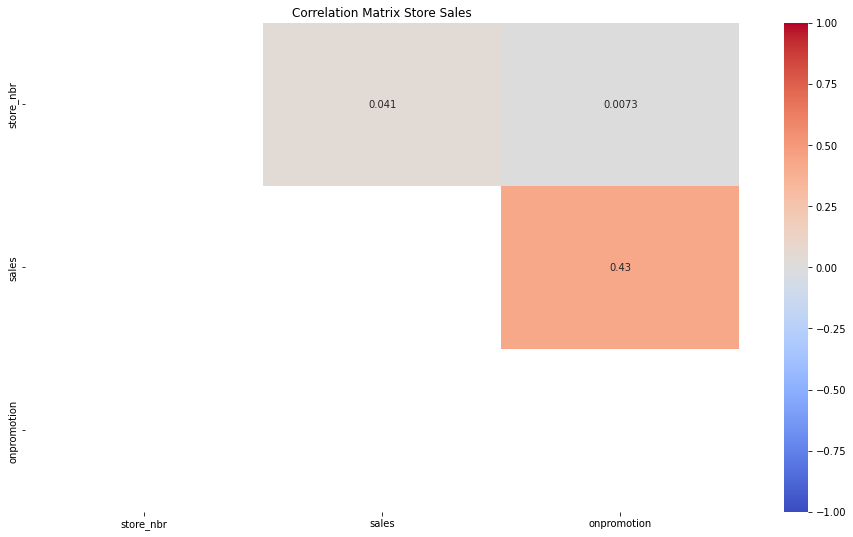

In [47]:
corr_mat = matTriangleHeatmap(train_df, 'Correlation Matrix Store Sales')
corr_mat

In [48]:
def bar_plot(df, labelx, labely):
    plt.figure(figsize=(16,9))
    sns.barplot(data=df, x=labelx, y=labely)

def time_series(df, labelx, labely):
    plt.figure(figsize=(16,9))
    sns.lineplot(data=df, x=labelx, y=labely)

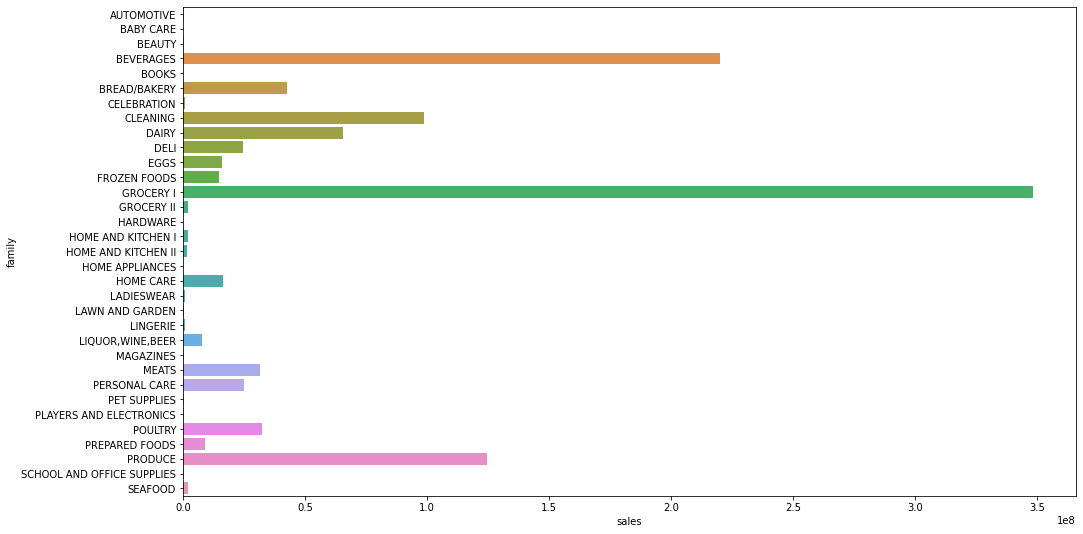

In [55]:
sales_df = train_join_df.groupby(by='family').sum().reset_index()
bar_plot(sales_df, 'sales', 'family')

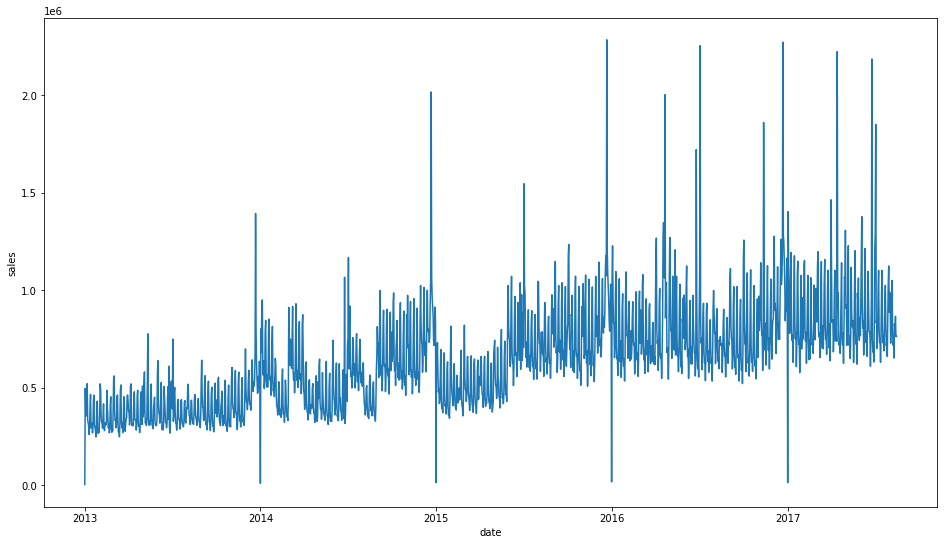

In [56]:
date_df = train_join_df.groupby(by='date').sum('sales').reset_index()
time_series(date_df, 'date', 'sales')

           date          sales  dcoilwtico  Year
0    2013-01-02  496092.417944       93.14  2013
1    2013-01-03  361461.231124       92.97  2013
2    2013-01-04  354459.677093       93.12  2013
3    2013-01-07  336122.801066       93.20  2013
4    2013-01-08  318347.777981       93.21  2013
...         ...            ...         ...   ...
1158 2017-08-09  734139.674010       49.59  2017
1159 2017-08-10  651386.911970       48.54  2017
1160 2017-08-11  826373.722022       48.81  2017
1161 2017-08-14  760922.406081       47.59  2017
1162 2017-08-15  762661.935939       47.57  2017

[1163 rows x 4 columns]


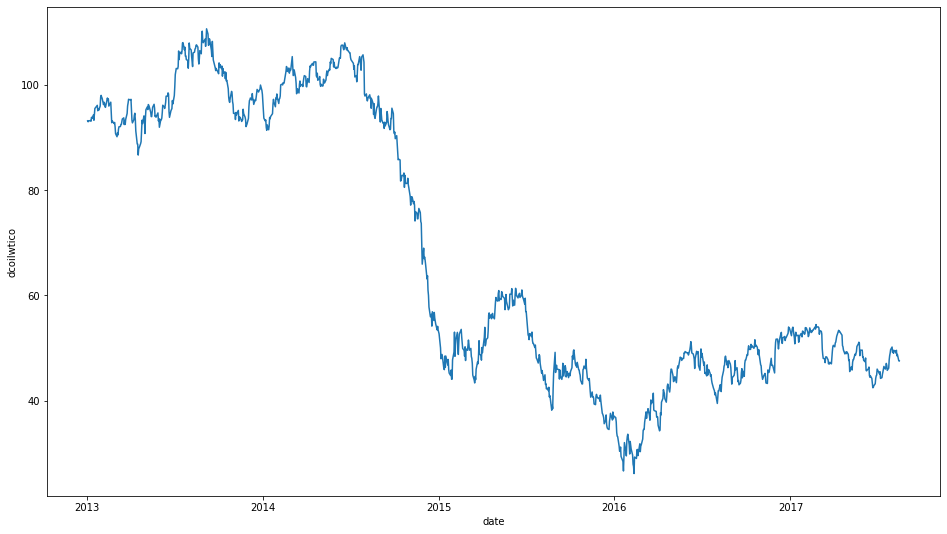

In [57]:
sales_and_oil_prices_per_date = pd.merge(left=train_df, right=oil_prices_df, on='date', how='inner')
sales_and_oil_prices_per_date = sales_and_oil_prices_per_date.groupby(by='date').agg({'sales': 'sum', 'dcoilwtico': 'first', 'Year': 'first'}).reset_index()
print(sales_and_oil_prices_per_date)
time_series(sales_and_oil_prices_per_date, 'date', 'dcoilwtico')

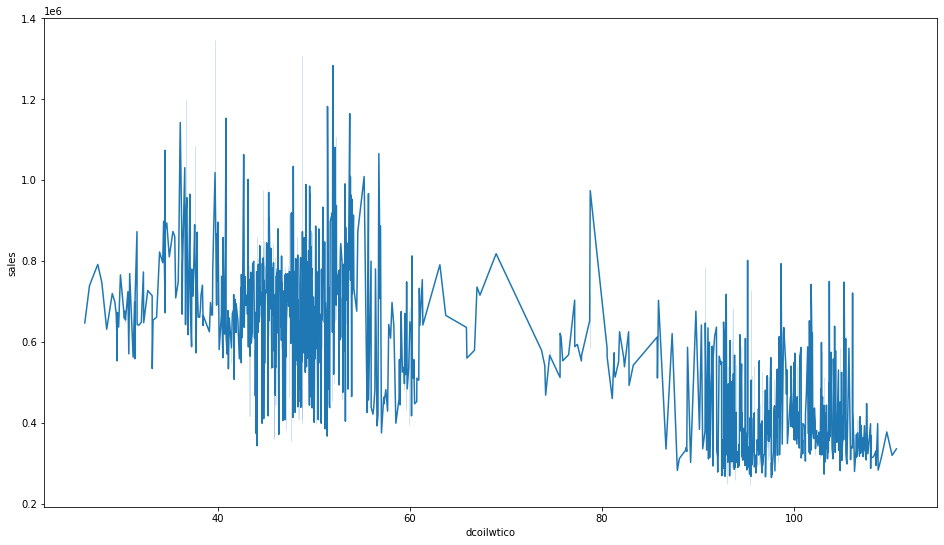

In [58]:
time_series(sales_and_oil_prices_per_date, 'dcoilwtico', 'sales')


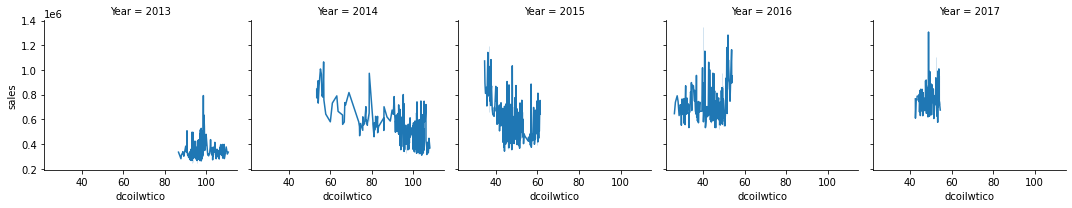

In [59]:
g = sns.FacetGrid(sales_and_oil_prices_per_date, col='Year')
g.map(sns.lineplot, "dcoilwtico", "sales")

## E. Análisis estadístico

In [60]:
train_join_df.describe()

,store_nbr,sales,onpromotion,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,is_holiday_local,is_holiday_national
count,3.038310e+06,3.038310e+06,3.038310e+06,3.038310e+06,3.038310e+06,3.038310e+06,3.038310e+06,3.038310e+06,3.038310e+06,3.038310e+06,3.038310e+06,3.038310e+06
mean,2.750000e+01,3.585222e+02,2.614175e+00,8.481481e+00,2.014841e+03,6.220528e+00,2.529736e+01,1.563578e+01,3.000587e+00,1.737783e+02,6.803519e-02,8.035191e-02
std,1.558579e+01,1.105708e+03,1.222453e+01,4.649735e+00,1.346643e+00,3.380216e+00,1.477357e+01,8.792654e+00,1.999560e+00,1.032878e+02,2.518063e-01,2.718373e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,2.014000e+03,3.000000e+00,1.300000e+01,8.000000e+00,1.000000e+00,8.600000e+01,0.000000e+00,0.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,2.015000e+03,6.000000e+00,2.500000e+01,1.600000e+01,3.000000e+00,1.700000e+02,0.000000e+00,0.000000e+00
75%,4.100000e+01,1.960000e+02,0.000000e+00,1.300000e+01,2.016000e+03,9.000000e+00,3.800000e+01,2.300000e+01,5.000000e+00,2.590000e+02,0.000000e+00,0.000000e+00
max,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,2.017000e+03,1.200000e+01,5.300000e+01,3.100000e+01,6.000000e+00,3.660000e+02,1.000000e+00,1.000000e+00


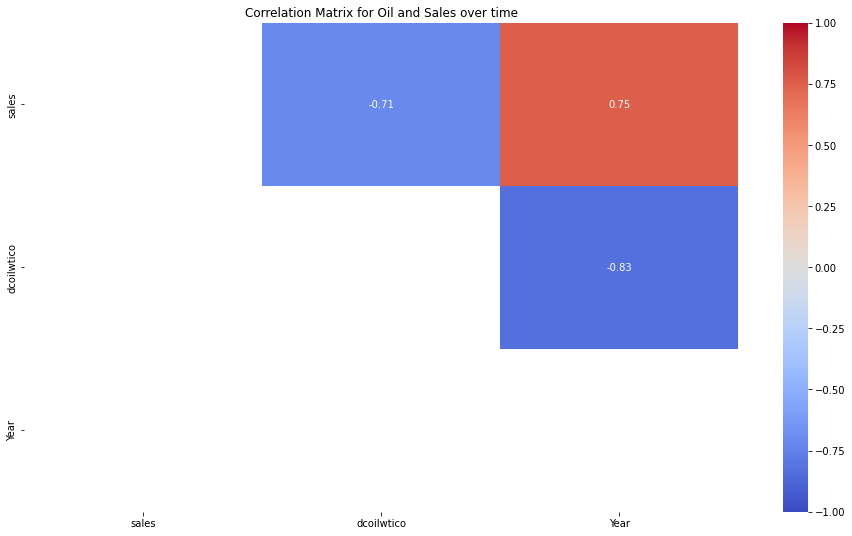

In [61]:
corr_mat_oil_sales = matTriangleHeatmap(sales_and_oil_prices_per_date, 'Correlation Matrix for Oil and Sales over time')

## F. Feature engineering

In [62]:
def label_encoder(df, *colsname):
    label_encoding = LabelEncoder()
    for name in colsname:
        newName = "{}_encode".format(name)
        df[newName] = label_encoding.fit_transform(df[name])
        df.drop(columns = name, inplace = True)

train_join_df_encode = train_join_df.copy()
label_encoder(train_join_df_encode, 'Is_quarter_end','Is_quarter_start','family','city_x','state','type')
train_join_df_encode = pd.merge(left= train_join_df_encode, right=oil_prices_df[['date','dcoilwtico']], on='date', how='left')
train_join_df_encode['oil_price'] = train_join_df_encode['dcoilwtico'].shift().rolling(7, min_periods=1).mean().fillna(train_join_df_encode['dcoilwtico'])
train_join_df_encode.drop(['dcoilwtico'], axis=1, inplace=True)
train_join_df_encode.at[0, 'oil_price'] = 93.14
train_join_df_encode

,date,store_nbr,sales,onpromotion,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,is_holiday_local,is_holiday_national,Is_quarter_end_encode,Is_quarter_start_encode,family_encode,city_x_encode,state_encode,type_encode,oil_price
0,2013-01-01,1,0.0,0,13,2013,1,1,1,1,1,0.0,1.0,0,1,0,18,12,3,93.140000
1,2013-01-02,1,2.0,0,13,2013,1,1,2,2,2,0.0,0.0,0,0,0,18,12,3,93.140000
2,2013-01-03,1,3.0,0,13,2013,1,1,3,3,3,0.0,0.0,0,0,0,18,12,3,93.140000
3,2013-01-04,1,3.0,0,13,2013,1,1,4,4,4,0.0,0.0,0,0,0,18,12,3,93.055000
4,2013-01-05,1,5.0,0,13,2013,1,1,5,5,5,0.0,1.0,0,0,0,18,12,3,93.076667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038305,2017-08-11,54,0.0,0,3,2017,8,32,11,4,223,0.0,1.0,0,0,32,5,10,2,49.228000
3038306,2017-08-12,54,1.0,1,3,2017,8,32,12,5,224,0.0,0.0,0,0,32,5,10,2,49.076000
3038307,2017-08-13,54,2.0,0,3,2017,8,32,13,6,225,0.0,0.0,0,0,32,5,10,2,49.076000
3038308,2017-08-14,54,0.0,0,3,2017,8,33,14,0,226,0.0,0.0,0,0,32,5,10,2,49.076000


In [63]:
train_join_df_encode.to_csv('./data/train_join_df_encoded.csv', index=False)

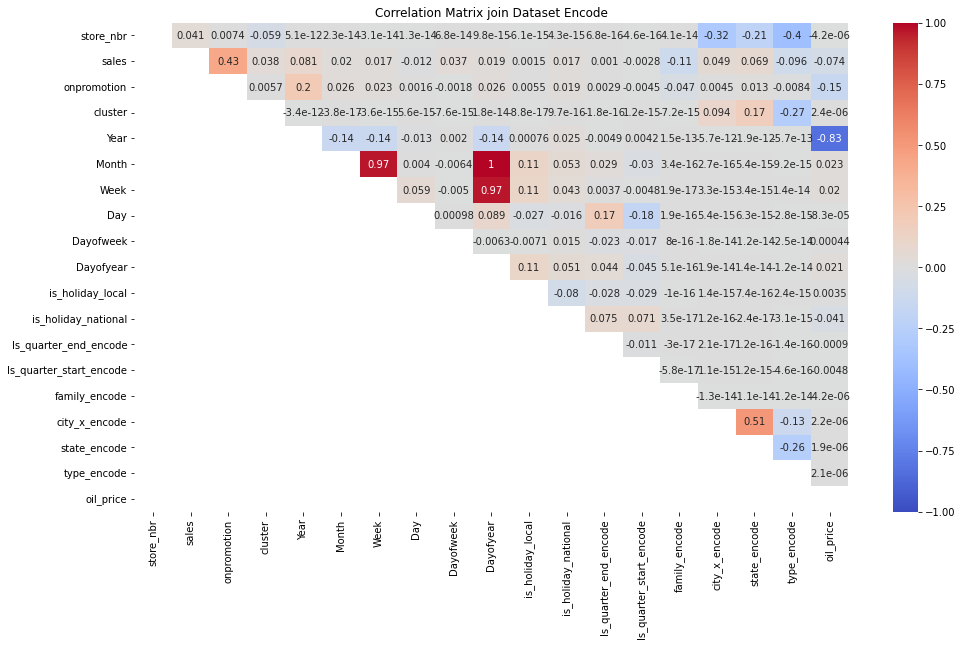

In [64]:
corr_mat_join_encode = matTriangleHeatmap(train_join_df_encode, 'Correlation Matrix join Dataset Encode')

In [65]:
train_join_df_encode.isnull().sum()

date                       0
store_nbr                  0
sales                      0
onpromotion                0
cluster                    0
Year                       0
Month                      0
Week                       0
Day                        0
Dayofweek                  0
Dayofyear                  0
is_holiday_local           0
is_holiday_national        0
Is_quarter_end_encode      0
Is_quarter_start_encode    0
family_encode              0
city_x_encode              0
state_encode               0
type_encode                0
oil_price                  0
dtype: int64

## G. Tareas previas al modelo

In [67]:
train_dataset_clean = pd.read_csv('./data/train_join_df_encoded.csv')
train_dataset_clean.drop('date', axis=1, inplace=True)
train_dataset_clean

,store_nbr,sales,onpromotion,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,is_holiday_local,is_holiday_national,Is_quarter_end_encode,Is_quarter_start_encode,family_encode,city_x_encode,state_encode,type_encode,oil_price
0,1,0.0,0,13,2013,1,1,1,1,1,0.0,1.0,0,1,0,18,12,3,93.140000
1,1,2.0,0,13,2013,1,1,2,2,2,0.0,0.0,0,0,0,18,12,3,93.140000
2,1,3.0,0,13,2013,1,1,3,3,3,0.0,0.0,0,0,0,18,12,3,93.140000
3,1,3.0,0,13,2013,1,1,4,4,4,0.0,0.0,0,0,0,18,12,3,93.055000
4,1,5.0,0,13,2013,1,1,5,5,5,0.0,1.0,0,0,0,18,12,3,93.076667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038305,54,0.0,0,3,2017,8,32,11,4,223,0.0,1.0,0,0,32,5,10,2,49.228000
3038306,54,1.0,1,3,2017,8,32,12,5,224,0.0,0.0,0,0,32,5,10,2,49.076000
3038307,54,2.0,0,3,2017,8,32,13,6,225,0.0,0.0,0,0,32,5,10,2,49.076000
3038308,54,0.0,0,3,2017,8,33,14,0,226,0.0,0.0,0,0,32,5,10,2,49.076000


In [24]:
# Train split
train_features, test_features, train_labels, test_labels = train_test_split(train_dataset_clean.drop('sales', axis=1), 
                                                            train_dataset_clean['sales'], train_size=0.8, random_state=43)
print(train_features.shape)
print(train_labels.shape)
# Unir al test de kaggle lo que se hizo en este modelo.
train_features

(2430648, 18)
(2430648,)


,store_nbr,onpromotion,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,is_holiday_local,is_holiday_national,Is_quarter_end_encode,Is_quarter_start_encode,family_encode,city_x_encode,state_encode,type_encode,oil_price
223050,4,0,9,2016,10,42,20,3,294,0.0,0.0,0,0,31,18,12,3,50.536
2004119,36,0,10,2015,1,2,9,4,9,0.0,0.0,0,0,20,11,6,4,49.648
215903,4,0,9,2015,12,49,2,2,336,0.0,0.0,0,0,27,18,12,3,40.700
444634,8,0,8,2016,8,33,15,0,228,1.0,0.0,0,0,29,18,12,3,43.114
2000654,36,1,10,2014,11,46,15,5,319,0.0,0.0,0,0,18,11,6,4,76.496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525776,28,33,10,2017,2,5,2,3,33,0.0,0.0,0,0,3,8,6,4,53.140
1439802,26,0,10,2015,2,8,16,0,47,0.0,1.0,0,0,19,8,6,3,51.136
2484501,45,0,11,2013,11,45,10,6,314,1.0,0.0,0,0,5,18,12,0,94.306
1613617,29,0,10,2014,11,46,13,3,317,0.0,0.0,0,0,22,8,6,4,77.804


### Definición de función de evaluación de modelos

In [72]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mean_squared_error = metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    print('explained_variance: ', np.around(explained_variance, 4))
    print('r2: ', np.around(r2, 4))
    # print('mean_absolute_error: ', np.around(mean_absolute_error, 4))
    # print('mean_squared_error: ', np.around(mean_squared_error, 4))
    # print('root_mean_squared_error: ', np.around(np.sqrt(mean_squared_error), 4))
    # print('mean_squared_log_error: ', np.around(mean_squared_log_error, 4))
    print('root_mean_squared_log_error: ', np.around(np.sqrt(mean_squared_log_error), 4))
    # print('median_absolute_error: ', np.around(median_absolute_error, 4))

## H. Modelado

In [73]:
# Join the models to use
simplefilter("ignore", category=ConvergenceWarning)
model_name = ['LR', 'AB', 'BR', 'GBR', 'ETR', 'HGBR', 'LSVM', 'DT', 'NN', 'RF',]
model_run = [LinearRegression(), AdaBoostRegressor(), BaggingRegressor(n_jobs = -1), GradientBoostingRegressor(),
            ExtraTreesRegressor(), HistGradientBoostingRegressor(), LinearSVR(), DecisionTreeRegressor(),
            MLPRegressor(), RandomForestRegressor()]
model_params = [{'n_jobs':[-1]},{'n_estimators':[50]},{'n_estimators':[10],'n_jobs':[-1]},{'n_estimators':[100]},
                {'n_estimators':[100],'n_jobs':[-1]},{'max_iter':[100]},{'max_iter':[1000]},{'max_features':['auto']},
                {'solver':['lbfgs'],'n_iter_no_change':[20]},{'n_estimators':[10], 'n_jobs':[-1]}]
models = []
for name, model, params in zip(model_name, model_run, model_params):
    models.append((name, model, params))

models

[('LR', LinearRegression(), {'n_jobs': [-1]}),
 ('AB', AdaBoostRegressor(), {'n_estimators': [50]}),
 ('BR', BaggingRegressor(n_jobs=-1), {'n_estimators': [10], 'n_jobs': [-1]}),
 ('GBR', GradientBoostingRegressor(), {'n_estimators': [100]}),
 ('ETR', ExtraTreesRegressor(), {'n_estimators': [100], 'n_jobs': [-1]}),
 ('HGBR', HistGradientBoostingRegressor(), {'max_iter': [100]}),
 ('LSVM', LinearSVR(), {'max_iter': [1000]}),
 ('DT', DecisionTreeRegressor(), {'max_features': ['auto']}),
 ('NN', MLPRegressor(), {'solver': ['lbfgs'], 'n_iter_no_change': [20]}),
 ('RF', RandomForestRegressor(), {'n_estimators': [10], 'n_jobs': [-1]})]

In [27]:
# Evaluate each model in turn
def evaluate_models(n, train_features, train_labels, test_features, test_labels, models, option='normalmode'):
    results = []
    names = []
    lst_preds = []
    for name, model, params in models:        
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(n_splits=n)

        # Choose best model
        best_model = GridSearchCV(model, scoring='neg_mean_squared_error', cv=tscv,
                                    refit=True, n_jobs=-1, param_grid=params)
        best_model.fit(train_features, train_labels)
        
        cv_results = best_model.score(train_features, train_labels)
        
        # Append to lists
        results.append(cv_results)
        names.append(name)
        
        # Results for test model and saving the model
        print("Results for {} on {}".format(name, option))
        print("Training score {}-{} with score: {}".format(name, option, cv_results))
        y_pred = pd.Series(best_model.predict(test_features), index=test_features.index).clip(0.0)
        lst_preds.append((y_pred))
        print('Test scores')
        regression_results(y_pred, test_labels)
        
        # Saving the model
        dump(best_model,"{}{}.joblib".format(name,option))
        print()
    
    return results, names, lst_preds
# https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

In [28]:
normal_results, normal_names, normal_y_pred = evaluate_models(3,train_features,train_labels,test_features,test_labels,models)
dump(normal_y_pred,"Normal_y_pred.joblib")

Results for LR on normalmode
Training score LRnormalmode with score: -963603.4599343282
Test scores
explained_variance:  -2.9639
r2:  -2.9639
root_mean_squared_log_error:  3.6296
Results for AB on normalmode
Training score ABnormalmode with score: -899507.0558070506
Test scores
explained_variance:  -0.7231
r2:  -0.883
root_mean_squared_log_error:  4.1178
Results for BR on normalmode
Training score BRnormalmode with score: -10198.149335980735
Test scores
explained_variance:  0.9241
r2:  0.9241
root_mean_squared_log_error:  0.4671
Results for GBR on normalmode
Training score GBRnormalmode with score: -366176.1337807508
Test scores
explained_variance:  0.4117
r2:  0.4117
root_mean_squared_log_error:  2.4457
Results for ETR on normalmode
Training score ETRnormalmode with score: -3.2121310860316146e-05
Test scores
explained_variance:  0.9304
r2:  0.9304
root_mean_squared_log_error:  0.5056
Results for HGBR on normalmode
Training score HGBRnormalmode with score: -132977.9962044275
Test score

['Normal_y_pred.joblib']

## I. Entrega de resultado